# 1D Heat Diffusion

In [62]:
import numpy
from matplotlib import pyplot
from scipy.sparse import coo_matrix
from sys import getsizeof

%matplotlib inline

In [63]:
#Set parameters
nt = 1000
sigma = 0.5
nx = 51
L = 1.0
dx = L / (nx - 1)
alpha = 1.22e-3 #conduction coefficient
dt = sigma * dx**2 / alpha

#Set up spatial grid
x = numpy.linspace(0.0, L, num = nx)

#Define initial temperature 
T0 = numpy.zeros(nx)
T0[0] = 100.0
T0[-1] = 0.0

In [64]:
def ftcs_d(T0, nt, dt, dx):
    """Perform forward time central space for 1D heat conduction
    with a Dirichlet boundary condition (fixed boundary)"""
    
    T = T0.copy()
    for i in range(nt):
        T[1:-1] = (T[1:-1] + alpha * dt / dx**2 * 
                   (T[:-2] - 2 * T[1:-1] + T[2:]))
        
        T[0] = T0[0]
        T[-1] = T0[-1]
        
    return T

In [65]:
def ftcs_n(T0, nt, dt, dx, q = 0.0):
    """Perform forward time central space for 1D heat conduction
    with a Neumann boundary condition (fixed derivative)"""
    
    T = T0.copy()
    for i in range(nt):
        T[1:-1] = (T[1:-1] + alpha * dt / dx**2 *
                   (T[:-2] - 2 * T[1:-1] + T[2:]))
        
        #Update left boundary Diri
        T[0] = T0[0]
        #Update right boundary - Neumann
        T[-1] = T[-2] + q * dx
        
    return T

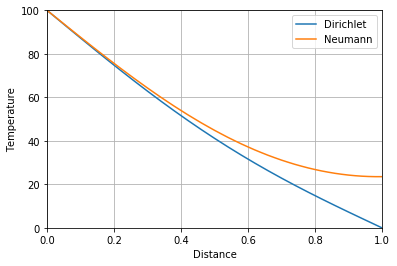

In [66]:
nt = 1000
Td = ftcs_d(T0, nt, dt, dx)
Tn = ftcs_n(T0, nt, dt, dx)
pyplot.plot(x, Td, label = 'Dirichlet')
pyplot.plot(x, Tn, label = 'Neumann')
pyplot.xlabel('Distance')
pyplot.ylabel('Temperature')
pyplot.legend()
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0)
pyplot.grid()

# Solve Implicit Scheme

In [67]:
def lhs(N, sigma):
    """Determine left hand side operator 
    of the 1D heat diffusion of the BTCS
    
    N : number f interior points
    sigma : alpha * dt / dx**2"""
    
    #Establish diagonal of lhs
    D = numpy.diag((2.0 + 1.0 / sigma) * numpy.ones(N))
    D[-1,-1] = 1.0 + 1.0 / sigma #Neumann last bounary
    
    U = numpy.diag(-1.0 * numpy.ones(N - 1), k = 1)
    L = numpy.diag(-1.0 * numpy.ones(N - 1), k = -1)
    
    #Newwwws Team, Asseeeemmmbbblllleee
    lhs = D + U + L
    
    
    return lhs

In [68]:
def rhs(T, sigma, qdx):
    """Establish the right hand side of the 1D heat diffusion of BTCS"""
   
    #Establish bulk of rhs array
    rhs = T[1:-1] / sigma
    #Adjust boundary
    rhs[0]  += T[0] 
    rhs[-1] += qdx
    
    return rhs

In [69]:
def btcs(T0, nt, dt, dx, alpha, q = 0.0):
    """Solve backware time central space implicitly"""
    
    T = T0.copy()
    sigma = alpha * dt / dx**2
    #Solve for qdx, needed for last entry of rhs
    qdx = q * dx
    #Determine length of LHS
    N = len(T0) - 2
    #Solve lhs operator
    A = lhs(N, sigma)
    for n in range(nt):
        #solve rhs operator at each time step
        b = rhs(T, sigma, qdx)
        #solve for central temperature points using linear algebra solver
        T[1:-1] = numpy.linalg.solve(A,b)
        #Left hand side boundary - Diri
        T[0] = T0[0]
        #Right hand side boundary - Neumann
        T[-1] = T[-2] + qdx
        
    return T

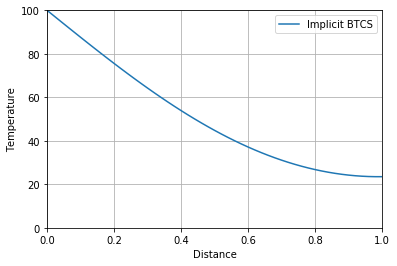

In [70]:
nt = 1000
sigma = 0.5
dt = sigma * dx**2 / alpha
T_imp = btcs(T0, nt, dt, dx, alpha)
pyplot.plot(x, T_imp, label = 'Implicit BTCS')
pyplot.xlabel('Distance')
pyplot.ylabel('Temperature')
pyplot.grid()
pyplot.legend()
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

# Utilize a Sparse vs a Dense Matrix


In [71]:
def lhs_s(N, sigma):
    """Determine left hand side operator 
    of the 1D heat diffusion of the BTCS
    
    N : number f interior points
    sigma : alpha * dt / dx**2"""
    
    #Establish diagonal of lhs
    D = numpy.diag((2.0 + 1.0 / sigma) * numpy.ones(N))
    D[-1,-1] = 1.0 + 1.0 / sigma #Neumann last bounary
    
    U = numpy.diag(-1.0 * numpy.ones(N - 1), k = 1)
    L = numpy.diag(-1.0 * numpy.ones(N - 1), k = -1)
    
    #Newwwws Team, Asseeeemmmbbblllleee
    lhs_dense = D + U + L
    
    lhs = coo_matrix(lhs_dense)
    
    return lhs

In [72]:
N = len(T0) - 2
sigma = alpha * dt / dx**2

In [73]:
dense = lhs(N, sigma)
sparse = lhs_s(N, sigma);

In [78]:
#compare the memory usage of both methods utiziling the system method Getsizeof
print(getsizeof(dense))
print(getsizeof(sparse))
print(getsizeof(dense) - getsizeof(sparse))

19320
56
19264
